#Background in Perception
- pyschometric function maps the decision probability in binary classification studies when teh stimuli are continuous
- an abstract image is shown and observations on perception is recorded depending on how test subjects view the image
- parameters of the se functions are modulated by attention, motivation, and other congnitive functions
#Task
- task is going to see if a CNN can classify if an image has horizonal lines
- make 1x30x30 of gaussian noise with random horizontal and vertical lines
- train val should be 100% accuracy
- then create a test set of images that have angles lines with slopes varying from -30 to 30
- how will the CNN classify these lines (vertical or horizontal)
- plot results (x -> slope of line, y -> probabilty of vertical line)

In [102]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-102-a8aed9fadacf>:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [103]:
# Parameters for the Gaussian distribution
mean = 0
std_dev = 1
image_shape = (1, 30, 30)  # Shape of the image (channels, height, width)
dataset_size = 5000

min_bar_thickness = 1
max_bar_thickness = 5

dataset = torch.zeros((dataset_size, *image_shape))
occluded_data = torch.zeros((dataset_size, *image_shape))
labels = torch.zeros(dataset_size,1)

for i in range(dataset_size):
  G  = np.random.randn(image_shape[1],image_shape[2])

  # add a random bar randomly
  i1 = np.random.choice(np.arange(2,28))
  i2 = np.random.choice(np.arange(2,6))
  if np.random.randn()>0:
    G[i1:i1+i2,] = 1 # horizontal
  else:
    G[:,i1:i1+i2] = 1 # vertical
    labels[i] = 1

  # add to the tensor
  dataset[i,:,:,:] = torch.Tensor(G).view(*image_shape)


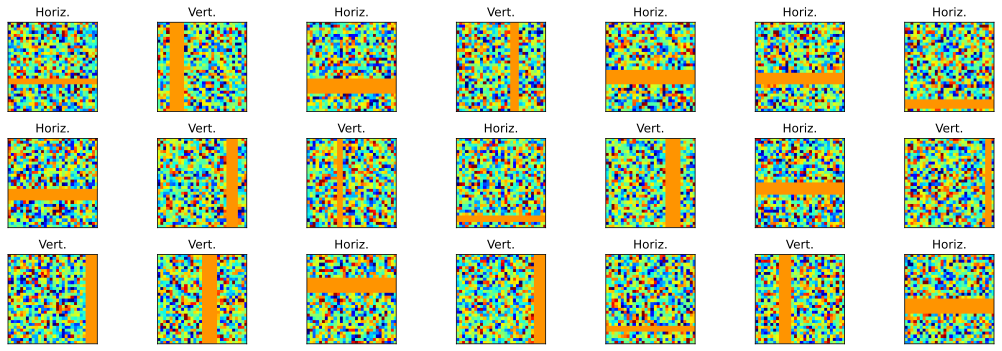

In [104]:
# visualize some images
fig,axs = plt.subplots(3,7,figsize=(15,5))

for i,ax in enumerate(axs.flatten()):
  whichpic = np.random.randint(dataset_size)
  G = np.squeeze( dataset[whichpic,:,:] )
  ax.imshow(G,vmin=-2,vmax=2,cmap='jet',extent=[-4,4,-4,4],origin='upper')

  title = 'Horiz.' if labels[whichpic].item()==0 else 'Vert.'
  ax.set_title(title)
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()
plt.show()

In [105]:
X_train, X_test, y_train,y_test = train_test_split(dataset, labels, test_size=0.1)

train_set = TensorDataset(X_train, y_train)
test_set = TensorDataset(X_test, y_test)

batchsize = 16
train_loader = DataLoader(train_set, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=test_set.tensors[0].shape[0])

In [106]:
train_loader.dataset.tensors[0].shape, test_loader.dataset.tensors[0].shape

(torch.Size([4500, 1, 30, 30]), torch.Size([500, 1, 30, 30]))

In [107]:
# create a class for the model
def createTheNet(printtoggle=False):

  class edgeNet(nn.Module):
    def __init__(self,printtoggle):
      super().__init__()

      ### convolution layers
      self.conv1 = nn.Conv2d( 1,5,kernel_size=3,stride=1,padding=1)
      # size: np.floor( (31+2*1-3)/1 )+1 = 31/2 = 15 (/2 b/c maxpool)

      self.conv2 = nn.Conv2d(5,10,kernel_size=3,stride=1,padding=1)
      # size: np.floor( (15+2*1-3)/1 )+1 = 15/2 = 7 (/2 b/c maxpool)

      # compute the number of units in FClayer (number of outputs of conv2)
      expectSize = np.floor( (7+2*0-1)/1 ) + 1 # fc1 layer has no padding or kernel, so set to 0/1
      expectSize = 10*int(expectSize**2)

      ### fully-connected layer
      self.fc1 = nn.Linear(expectSize,15)

      ### output layer
      self.out = nn.Linear(15,1)

      # toggle for printing out tensor sizes during forward prop
      self.print = printtoggle

    # forward pass
    def forward(self,x):

      print(f'Input: {x.shape}') if self.print else None

      # convolution -> maxpool -> relu
      x = F.relu(F.max_pool2d(self.conv1(x),2))
      print(f'Layer conv1: {x.shape}') if self.print else None

      # and again: convolution -> maxpool -> relu
      x = F.relu(F.max_pool2d(self.conv2(x),2))
      print(f'Layer conv2: {x.shape}') if self.print else None

      # reshape for linear layer
      nUnits = x.shape.numel()/x.shape[0]
      x = x.view(-1,int(nUnits))
      if self.print: print(f'Vectorize: {x.shape}')

      # linear layers
      x = F.relu(self.fc1(x))
      if self.print: print(f'Layer fc1: {x.shape}')
      x = self.out(x)
      if self.print: print(f'Layer out: {x.shape}')

      return x

  # create the model instance
  net = edgeNet(printtoggle)

  # loss function
  lossfun = nn.BCEWithLogitsLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)

  return net,lossfun,optimizer

In [108]:
net, lossfun, optimizer= createTheNet()

X,y = next(iter(train_loader))
yHat = net(X)

loss = lossfun(yHat,y)

print(loss)

tensor(0.6915, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [109]:
numepochs = 10
def trainTheModel(train_loader, test_loader):
  net, lossfun, optimizer = createTheNet()

  trainAccs = []
  testAccs = []
  trainLosses = []
  testLosses = []

  for epoch in range(numepochs):
    batchLoss = []
    batchAcc = []
    net.train()
    for X,y in train_loader:
      yHat = net(X)
      loss = lossfun(yHat, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and error from this batch
      batchLoss.append(loss.item())

      yy = torch.sigmoid(yHat)

      batchAcc.append( torch.mean(((yy>.5).float().detach() == y).float()).item() )

    trainLosses.append(np.mean(batchLoss))
    trainAccs.append(100*np.mean(batchAcc))
    net.eval()
    X,y = next(iter(test_loader))
    with torch.no_grad():
      yHat = net(X)
      loss = lossfun(yHat, y)

    yy = torch.sigmoid(yHat)
    testLosses.append(loss.item())
    testAccs.append(100*torch.mean(((yy>.5).float().detach() == y).float()).item() )
  return trainLosses, testLosses, trainAccs, testAccs, net

In [110]:
trainLosses, testLosses,trainAccs,testAccs, net = trainTheModel(train_loader,test_loader)

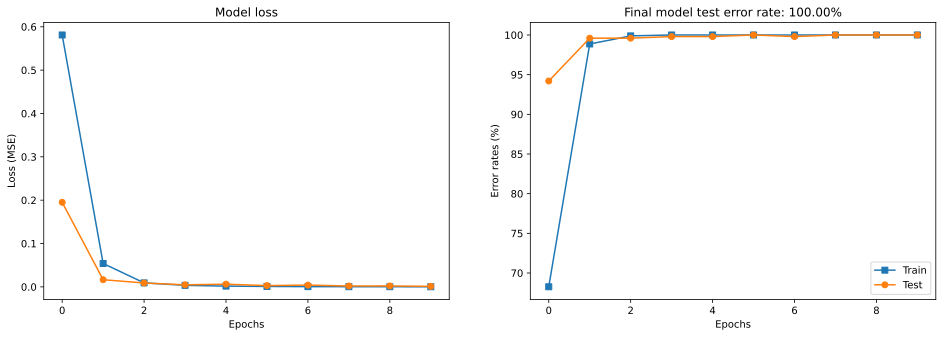

In [111]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLosses,'s-',label='Train')
ax[0].plot(testLosses,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAccs,'s-',label='Train')
ax[1].plot(testAccs,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {testAccs[-1]:.2f}%')
ax[1].legend()

plt.show()

In [112]:
image_shape
imgSize = image_shape[1]

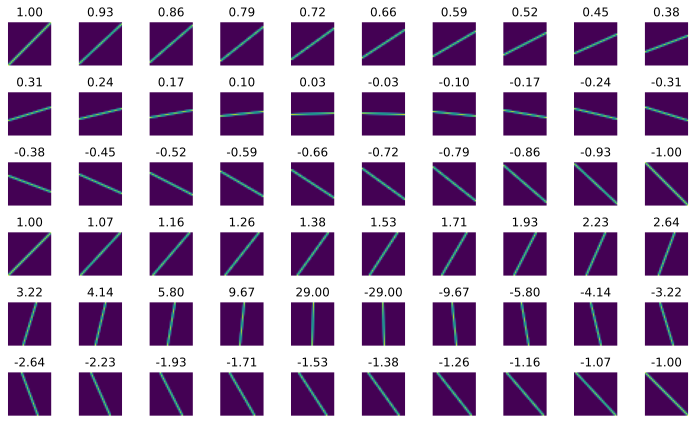

In [113]:
### create lines in images
from skimage.draw import line_aa

fig,ax = plt.subplots(6,10,figsize=(10,6))
imgs   = np.zeros((2*imgSize,1,imgSize,imgSize))
slopes = np.zeros(2*imgSize)

a = ax.flatten()
for i in range(imgSize):

  ### create lines with |slope|<1
  # point coords
  p1 = [0,i]
  p2 = [imgSize-p1[0]-1,imgSize-p1[1]-1]
  slopes[i] = (p2[1]-p1[1])/(p2[0]-p1[0]+1e-10)

  # create the lines
  rows,cols,val = line_aa(p1[1],p1[0],p2[1],p2[0]) #  y1,x1,y2,x2
  imgs[i,0,rows,cols] = val

  # plot
  a[i].imshow(imgs[i,0,:,:],origin='lower')
  a[i].set_title('%.2f'%slopes[i])
  a[i].axis('off')


  ### create lines with |slope|>1
  # point coords
  p1 = [i,0]
  p2 = [imgSize-p1[0]-1,imgSize-p1[1]-1]
  slopes[i+imgSize] = (p2[1]-p1[1])/(p2[0]-p1[0]+1e-10)

  # create the lines
  rows,cols,val = line_aa(p1[1],p1[0],p2[1],p2[0]) #  y1,x1,y2,x2
  imgs[i+imgSize,0,rows,cols] = val

  # plot
  a[i+imgSize].imshow(imgs[i+imgSize,0,:,:],origin='lower')
  a[i+imgSize].set_title('%.2f'%slopes[i+imgSize])
  a[i+imgSize].axis('off')

plt.tight_layout()
plt.show()

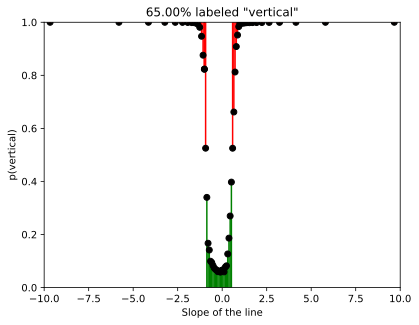

In [114]:
# run the images through the model

# randomly shuffle the images, just to be on the safe side...
# and also convert to tensor...
ridx = np.random.permutation(range(imgs.shape[0]))
imgT = torch.tensor(imgs[ridx,:,:,:].astype(np.float32))


# now generate the prediction (horizontal or vertical)
net.eval()
yHat = torch.sigmoid( net(imgT) ).detach()

# plot the results (make sure the slopes use the same randomization)
for i in range(len(slopes)):


  if yHat[i]>.5:
    plt.plot([slopes[ridx[i]],slopes[ridx[i]]],[1,yHat[i].item()],'r')
  else:
    plt.plot([slopes[ridx[i]],slopes[ridx[i]]],[0,yHat[i].item()],'g')

plt.plot(slopes[ridx],yHat,'ko')
plt.xlabel('Slope of the line')
plt.ylabel('p(vertical)')
plt.title('%.2f%% labeled "vertical"' %torch.mean(100*(yHat>.5).float()).item())
plt.ylim([0,1])
plt.xlim([-10,10]) # note: this actually clips two data points
plt.show()

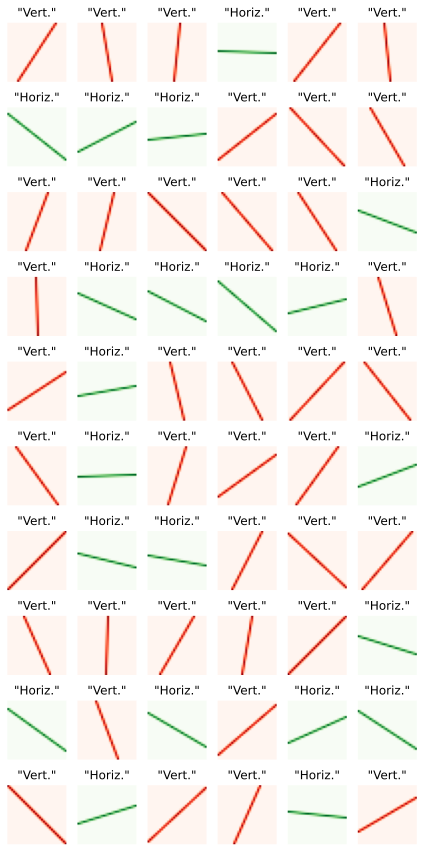

In [115]:
fig,ax = plt.subplots(10,6,figsize=(6,12))

for i,a in enumerate(ax.flatten()):

  # show the line-image (make sure to use the randomization index)
  if yHat[i]>.5:
    a.imshow(imgs[ridx[i],0,:,:],origin='lower',cmap='Reds')
  else:
    a.imshow(imgs[ridx[i],0,:,:],origin='lower',cmap='Greens')

  # and the title
  title = '"Vert."' if yHat[i].detach()>.5 else '"Horiz."'
  a.set_title(title)
  a.axis('off')

plt.tight_layout()
plt.show()